In [1]:
# ส่วนที่ 1: การนำเข้าไลบรารี
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pycaret.regression import *
from pycaret.regression import setup, create_model, tune_model, finalize_model, save_model, evaluate_model
from sklearn.model_selection import train_test_split  # เพิ่มการนำเข้า train_test_split


In [2]:
# ส่วนที่ 2: การโหลดข้อมูล
file_path = 'C:\python\pm2_5\data\export-4B7B6566022D-1d.xlsx'  # หรือ .csv ตามที่คุณมี

try:
    df = pd.read_csv(file_path)
except:
    # หากเป็น Excel ให้ใช้ read_excel แทน
    df = pd.read_excel(file_path)


In [3]:
# ส่วนที่ 3: ตรวจสอบโครงสร้างข้อมูลเบื้องต้น
print("Original Dataset Shape:", df.shape)
print("\nColumn Names:", df.columns.tolist())
print("\nData Types:\n", df.dtypes)
print("\nMissing Values:\n", df.isnull().sum())

Original Dataset Shape: (605, 7)

Column Names: ['Unnamed: 0', 'timestamp', 'timezone', 'humidity', 'pm_10', 'pm_2_5', 'temperature']

Data Types:
 Unnamed: 0              int64
timestamp      datetime64[ns]
timezone               object
humidity              float64
pm_10                 float64
pm_2_5                float64
temperature           float64
dtype: object

Missing Values:
 Unnamed: 0     0
timestamp      0
timezone       0
humidity       0
pm_10          0
pm_2_5         0
temperature    0
dtype: int64


In [4]:
# ส่วนที่ 4: การกำจัดค่า 0 และ null
print("\nจำนวนค่า null ในแต่ละคอลัมน์:")
print(df.isnull().sum())

numeric_columns = ['humidity', 'pm_10', 'pm_2_5', 'temperature']
for col in numeric_columns:
    zero_count = (df[col] == 0).sum()
    print(f"จำนวนค่า 0 ในคอลัมน์ {col}: {zero_count}")

df_clean = df.dropna()
print(f"จำนวนแถวหลังจากกำจัดค่า null: {len(df_clean)} (กำจัดไป {len(df) - len(df_clean)} แถว)")

zero_not_allowed = ['humidity', 'pm_10', 'pm_2_5', 'temperature'] 

mask = pd.Series(True, index=df_clean.index)
for col in zero_not_allowed:
    mask = mask & (df_clean[col] != 0)

df_no_zeros = df_clean[mask]
print(f"จำนวนแถวหลังจากกำจัดค่า 0: {len(df_no_zeros)} (กำจัดไป {len(df_clean) - len(df_no_zeros)} แถว)")

print("\nข้อมูลทางสถิติหลังจากกำจัดค่า 0 และ null:")
print(df_no_zeros[numeric_columns].describe())

df = df_no_zeros.copy()


จำนวนค่า null ในแต่ละคอลัมน์:
Unnamed: 0     0
timestamp      0
timezone       0
humidity       0
pm_10          0
pm_2_5         0
temperature    0
dtype: int64
จำนวนค่า 0 ในคอลัมน์ humidity: 0
จำนวนค่า 0 ในคอลัมน์ pm_10: 0
จำนวนค่า 0 ในคอลัมน์ pm_2_5: 0
จำนวนค่า 0 ในคอลัมน์ temperature: 0
จำนวนแถวหลังจากกำจัดค่า null: 605 (กำจัดไป 0 แถว)
จำนวนแถวหลังจากกำจัดค่า 0: 605 (กำจัดไป 0 แถว)

ข้อมูลทางสถิติหลังจากกำจัดค่า 0 และ null:
         humidity       pm_10      pm_2_5  temperature
count  605.000000  605.000000  605.000000   605.000000
mean    83.509950    8.520169    7.338330    28.603848
std      5.172982    7.552615    6.600940     1.467708
min     71.708885    0.145898    0.040491    24.672013
25%     79.681826    2.880850    2.362445    27.547905
50%     83.325522    5.893363    4.982412    28.662485
75%     86.654160   12.191420   10.727273    29.631049
max     98.989814   48.086157   39.105415    32.470368


In [5]:
# ส่วนที่ 5: แปลงคอลัมน์ timestamp เป็น datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

df['date'] = df['timestamp'].dt.date
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month
df['day'] = df['timestamp'].dt.day
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek

df.head()


,Unnamed: 0,timestamp,timezone,humidity,pm_10,pm_2_5,temperature,date,year,month,day,hour,day_of_week
0,0,2023-03-30 07:00:00,Asia/Bangkok,79.515108,15.009398,13.261742,29.467521,2023-03-30,2023,3,30,7,3
1,1,2023-03-31 07:00:00,Asia/Bangkok,78.898093,24.735220,20.942335,28.861087,2023-03-31,2023,3,31,7,4
2,2,2023-04-01 07:00:00,Asia/Bangkok,79.954988,20.175547,17.961679,29.059624,2023-04-01,2023,4,1,7,5
3,3,2023-04-02 07:00:00,Asia/Bangkok,78.147551,21.045487,18.405086,29.247009,2023-04-02,2023,4,2,7,6
4,4,2023-04-03 07:00:00,Asia/Bangkok,77.019334,14.021567,12.596624,29.835349,2023-04-03,2023,4,3,7,0


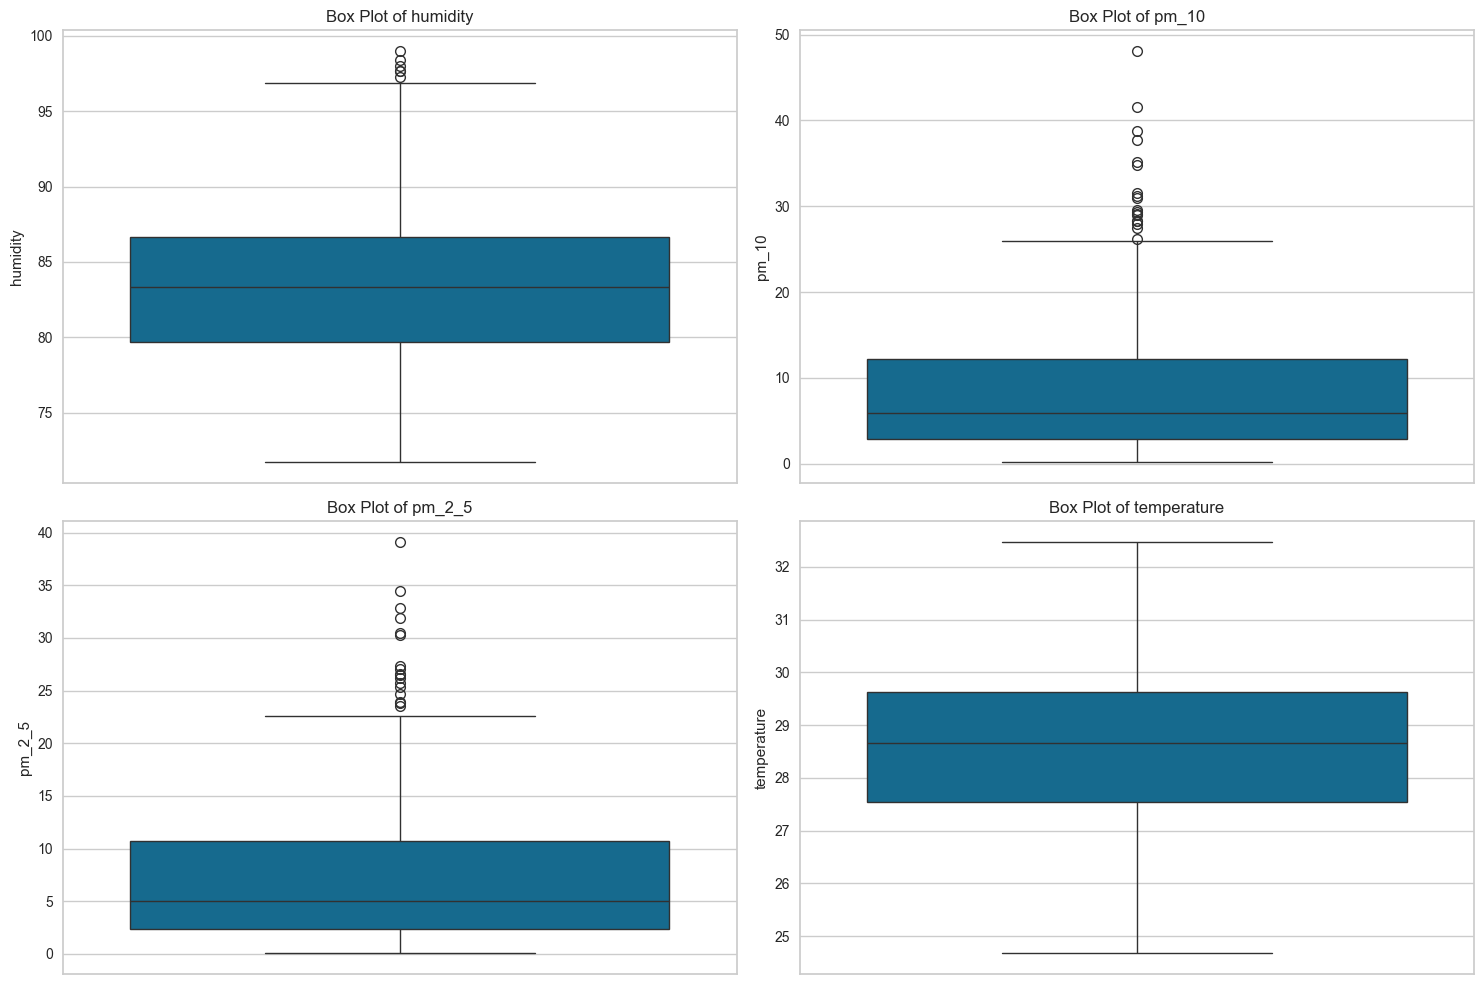

In [6]:
# ส่วนที่ 6: การตรวจสอบและจัดการ outliers
df[numeric_columns].describe()

plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(y=df[col])
    plt.title(f'Box Plot of {col}')

plt.tight_layout()
plt.show()


Outliers in humidity: 6
Outliers in pm_10: 18
Outliers in pm_2_5: 17
Outliers in temperature: 0


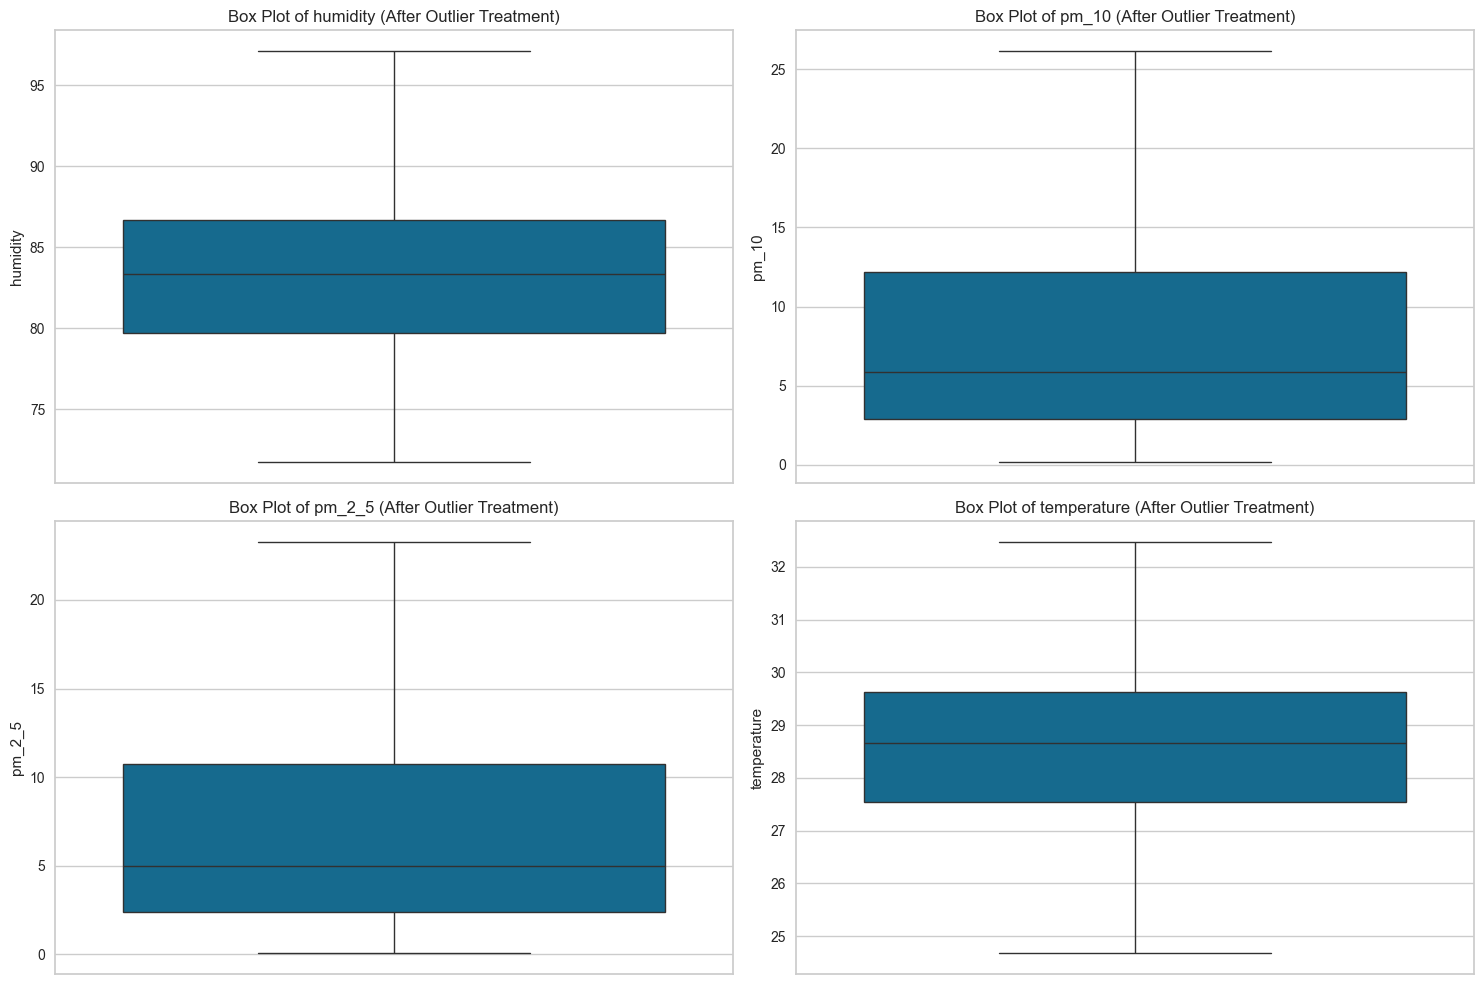

In [7]:
# ส่วนที่ 7: การจัดการ outliers ด้วยวิธี IQR
def handle_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers_count = len(df[(df[column] < lower_bound) | (df[column] > upper_bound)])
    print(f"Outliers in {column}: {outliers_count}")
    
    df_clean = df.copy()
    df_clean.loc[df_clean[column] < lower_bound, column] = lower_bound
    df_clean.loc[df_clean[column] > upper_bound, column] = upper_bound
    
    return df_clean

for col in numeric_columns:
    df = handle_outliers(df, col)

plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(y=df[col])
    plt.title(f'Box Plot of {col} (After Outlier Treatment)')

plt.tight_layout()
plt.show()


In [8]:
# ส่วนที่ 8: การตรวจสอบและจัดการค่าที่หายไป (ถ้ายังมี)
print("Missing Values After Outlier Treatment:\n", df.isnull().sum())

for col in numeric_columns:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True)

print("Missing Values After Imputation:\n", df.isnull().sum())


Missing Values After Outlier Treatment:
 Unnamed: 0     0
timestamp      0
timezone       0
humidity       0
pm_10          0
pm_2_5         0
temperature    0
date           0
year           0
month          0
day            0
hour           0
day_of_week    0
dtype: int64
Missing Values After Imputation:
 Unnamed: 0     0
timestamp      0
timezone       0
humidity       0
pm_10          0
pm_2_5         0
temperature    0
date           0
year           0
month          0
day            0
hour           0
day_of_week    0
dtype: int64


Correlation Matrix:
              humidity  pm_10  pm_2_5  temperature
humidity         1.00  -0.48   -0.48        -0.83
pm_10           -0.48   1.00    1.00         0.43
pm_2_5          -0.48   1.00    1.00         0.43
temperature     -0.83   0.43    0.43         1.00


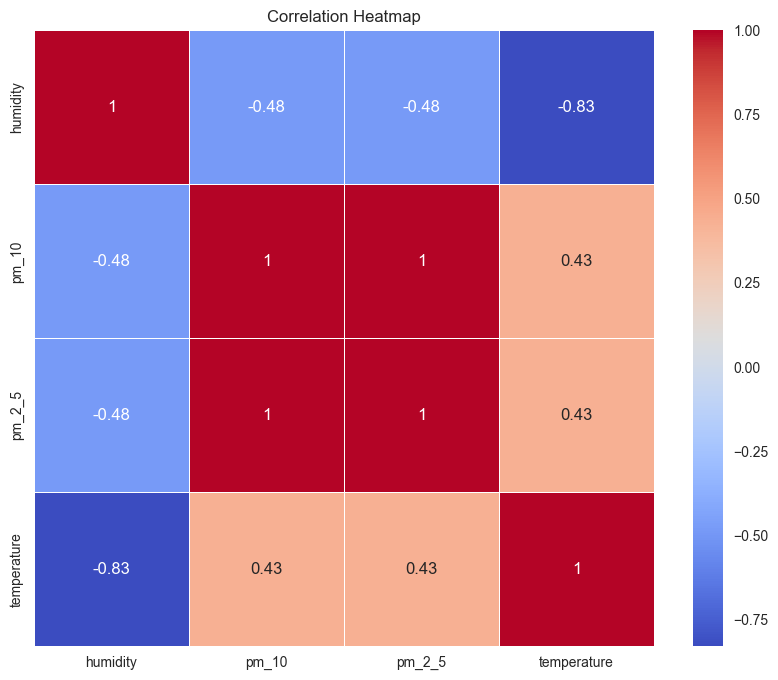

In [9]:
# ส่วนที่ 9: การวิเคราะห์ความสัมพันธ์ระหว่างตัวแปร
correlation = df[numeric_columns].corr().round(2)
print("Correlation Matrix:\n", correlation)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

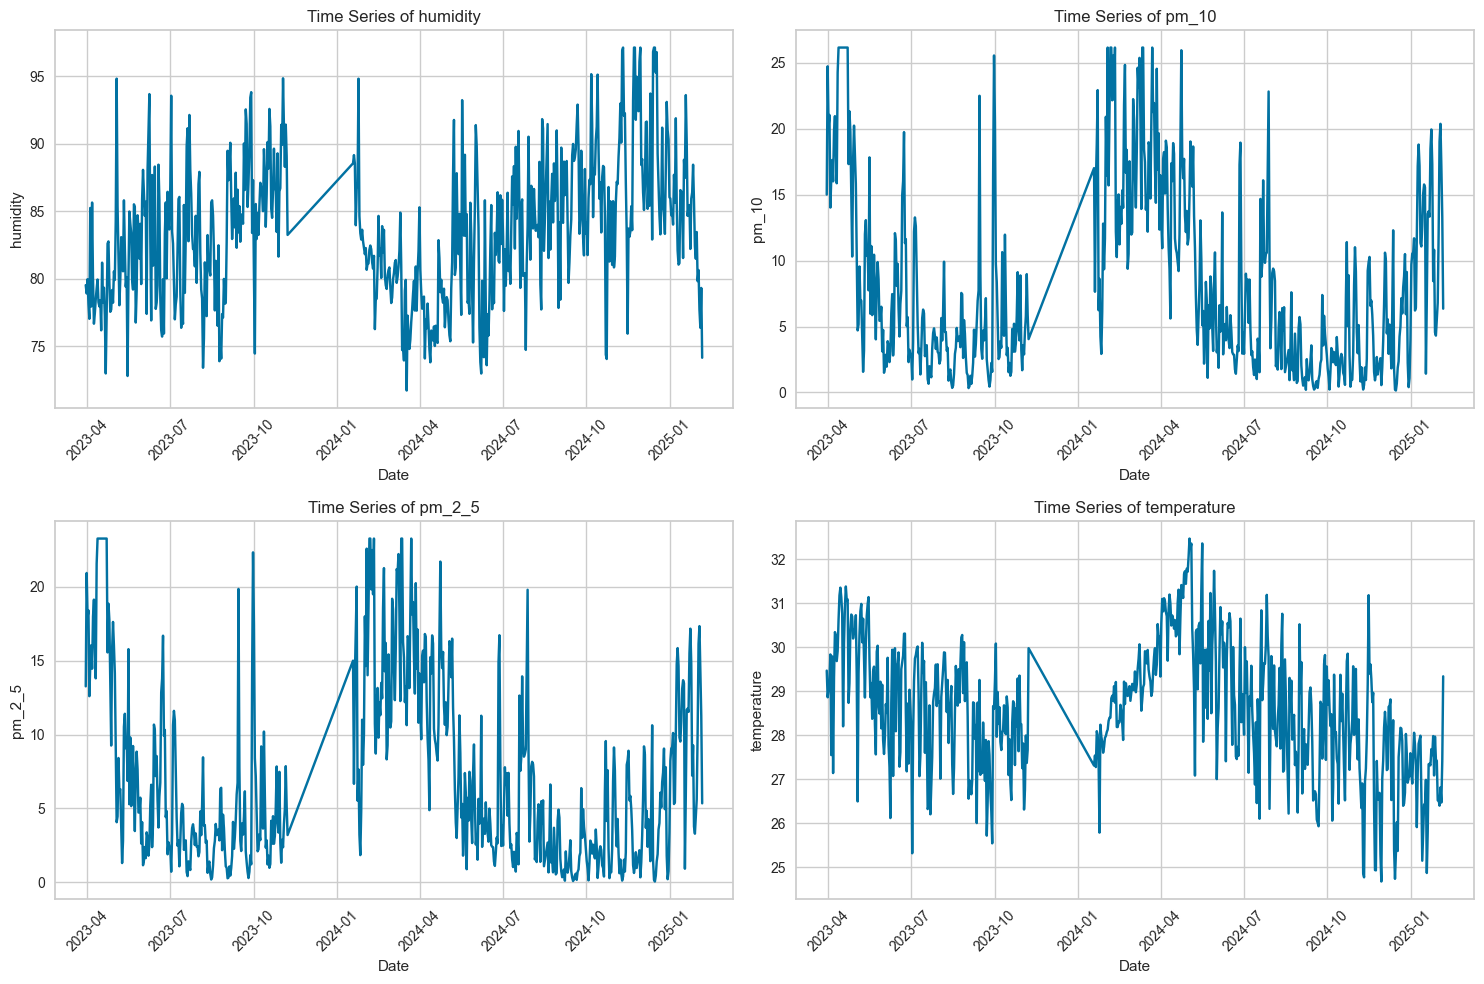

In [10]:
# ส่วนที่ 10: การวิเคราะห์แนวโน้มตามเวลา
plt.figure(figsize=(15, 10))

for i, col in enumerate(numeric_columns, 1):
    plt.subplot(2, 2, i)
    plt.plot(df['timestamp'], df[col])
    plt.title(f'Time Series of {col}')
    plt.xlabel('Date')
    plt.ylabel(col)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [21]:
# ส่วนที่ 11: การเตรียมข้อมูลสำหรับการใช้งานใน pycaret
# สร้างฟีเจอร์ใหม่ที่เกี่ยวข้องกับ temperature และ humidity
df['temp_humidity_ratio'] = df['temperature'] / df['humidity']
df['temp_humidity_diff'] = df['temperature'] - df['humidity']

# สร้างฟีเจอร์ใหม่ที่เกี่ยวข้องกับ pm_10
df['pm10_squared'] = df['pm_10'] ** 2
df['pm10_cubed'] = df['pm_10'] ** 3
df['pm10_humidity'] = df['pm_10'] * df['humidity']
df['pm10_temp'] = df['pm_10'] * df['temperature']
df['pm10_relative'] = df['pm_10'] / (df['humidity'] + 1)
df['pm10_weighted'] = df['pm_10'] * (df['temperature'] / (df['humidity'] + 1))

# ลดความสำคัญของ pm_10 โดยการสร้างฟีเจอร์ใหม่ที่มีความสัมพันธ์กับ temperature และ humidity มากขึ้น
df['temp_squared'] = df['temperature'] ** 2
df['humidity_squared'] = df['humidity'] ** 2

target_column = 'pm_2_5'  # เปลี่ยนเป็นคอลัมน์ target ที่คุณต้องการทำนาย
# เพิ่ม temperature ใน model_features
model_features = ['humidity', 'pm_10', 'temperature', 'temp_humidity_ratio', 'temp_humidity_diff', 'pm10_squared', 'pm10_cubed', 'pm10_humidity', 'pm10_temp', 'pm10_relative', 'pm10_weighted', 'temp_squared', 'humidity_squared']

# สร้าง model_df
model_df = df[model_features + [target_column]].copy()

# ตรวจสอบความสัมพันธ์ระหว่างฟีเจอร์ต่าง ๆ
correlation_matrix = model_df.corr()
print(correlation_matrix)

# เลือกฟีเจอร์ที่มีความสัมพันธ์กันน้อยกว่า threshold ที่กำหนด
threshold = 0.95  # เพิ่ม threshold เพื่อให้ฟีเจอร์สำคัญไม่ถูกลบ
columns_to_drop = [
    column for column in correlation_matrix.columns
    if any(correlation_matrix[column].abs() > threshold) and column not in [target_column, 'humidity', 'pm_10', 'temperature']
]

# ตรวจสอบฟีเจอร์ที่ถูกลบ
print("Columns to drop due to high correlation:", columns_to_drop)

# ลบฟีเจอร์ที่มีความสัมพันธ์สูงเกิน threshold
model_df = model_df.drop(columns=columns_to_drop)

# ตรวจสอบผลลัพธ์
print(f"Data prepared for modeling: {model_df.shape}")
print("Remaining columns in model_df:", model_df.columns.tolist())

if model_df.isnull().sum().sum() > 0:
    print("Warning: There are still missing values in the model DataFrame")
    model_df.dropna(inplace=True)

print(f"Data prepared for modeling: {model_df.shape}")
print(model_df.columns)  # ตรวจสอบคอลัมน์ใน DataFrame
model_df.head()

# ตรวจสอบคอลัมน์ใน df
print("Columns in df:", df.columns.tolist())
print("Sample of df:")
print(df.head())

# ตรวจสอบคอลัมน์ใน model_df
print("Columns in model_df:", model_df.columns.tolist())
print("Sample of model_df:")
print(model_df.head())

# แบ่งข้อมูล
X = model_df.drop(target_column, axis=1)
y = model_df[target_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# รวม X_train และ y_train
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

# ตรวจสอบคอลัมน์ใน train_data
print("Columns in train_data after split:", train_data.columns.tolist())
print("Sample of train_data after split:")
print(train_data.head())

# ตรวจสอบว่าคอลัมน์ที่จำเป็นมีอยู่หรือไม่
required_columns = ['humidity', 'pm_10', 'temperature', 'pm_2_5']
missing_columns = [col for col in required_columns if col not in train_data.columns]
if missing_columns:
    raise KeyError(f"Missing columns in train_data: {missing_columns}")

# เลือกเฉพาะคอลัมน์ที่จำเป็น
train_data = train_data[required_columns]

print("Columns in train_data:", train_data.columns.tolist())
print("Sample of train_data:")
print(train_data.head())


                     humidity     pm_10  temperature  temp_humidity_ratio  \
humidity             1.000000 -0.475294    -0.826057            -0.960042   
pm_10               -0.475294  1.000000     0.427339             0.472759   
temperature         -0.826057  0.427339     1.000000             0.945147   
temp_humidity_ratio -0.960042  0.472759     0.945147             1.000000   
temp_humidity_diff  -0.991651  0.479270     0.891835             0.986827   
pm10_squared        -0.393700  0.957150     0.349611             0.391064   
pm10_cubed          -0.333861  0.885128     0.300182             0.333905   
pm10_humidity       -0.431173  0.997472     0.392532             0.429056   
pm10_temp           -0.500240  0.997616     0.472264             0.509951   
pm10_relative       -0.513982  0.997745     0.457388             0.511183   
pm10_weighted       -0.535442  0.992777     0.498868             0.544789   
temp_squared        -0.821945  0.428718     0.999433             0.944365   

In [22]:
# ส่วนที่ 12: การแบ่งข้อมูลสำหรับการสร้างโมเดลป้องกัน Overfitting
X = model_df.drop(target_column, axis=1)
y = model_df[target_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)
# ตรวจสอบข้อมูลบางส่วน
print(train_data.head())  # ดูข้อมูล 5 แถวแรก
print(train_data.info())  # ตรวจสอบประเภทข้อมูลและข้อมูลที่หายไป

# ตรวจสอบข้อมูลที่มีค่าผิดปกติหรือไม่
print(train_data.describe())  # ตรวจสอบค่าเฉลี่ยและค่าต่ำสุด/สูงสุดของตัวแปร

# Ensure required columns are present
required_columns = ['humidity', 'pm_10', 'temperature', 'pm_2_5']
train_data = train_data[required_columns]

print("Columns in train_data:", train_data.columns.tolist())
print("Sample of train_data:")
print(train_data.head())



      humidity      pm_10  temperature     pm_2_5
563  83.313021   5.933670    28.027234   4.939508
604  74.136563   6.352747    29.337970   5.336689
570  84.685096  10.535271    26.900071   9.050794
444  90.974697   0.864394    26.240425   0.617391
304  76.314215  13.985586    29.693473  12.278298
<class 'pandas.core.frame.DataFrame'>
Index: 423 entries, 563 to 102
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   humidity     423 non-null    float64
 1   pm_10        423 non-null    float64
 2   temperature  423 non-null    float64
 3   pm_2_5       423 non-null    float64
dtypes: float64(4)
memory usage: 16.5 KB
None
         humidity       pm_10  temperature      pm_2_5
count  423.000000  423.000000   423.000000  423.000000
mean    83.645054    8.106254    28.611359    7.001228
std      5.112558    6.815473     1.497300    6.048388
min     71.708885    0.145898    24.672013    0.040491
25%     79.942424    2.838

In [23]:
# ตรวจสอบข้อมูลใน train_data
print(train_data.head())
print(train_data.columns)

      humidity      pm_10  temperature     pm_2_5
563  83.313021   5.933670    28.027234   4.939508
604  74.136563   6.352747    29.337970   5.336689
570  84.685096  10.535271    26.900071   9.050794
444  90.974697   0.864394    26.240425   0.617391
304  76.314215  13.985586    29.693473  12.278298
Index(['humidity', 'pm_10', 'temperature', 'pm_2_5'], dtype='object')


In [26]:
# ส่วนที่ 13: การใช้งาน pycaret เพื่อสร้างโมเดลทำนาย PM2.5
# ตรวจสอบข้อมูลที่เตรียมไว้
print("Train data shape:", train_data.shape)
print("Columns in train_data:", train_data.columns.tolist())

# ตรวจสอบค่าที่ไม่ถูกต้อง
print("Infinity check:", np.isinf(train_data.select_dtypes(include=['number'])).sum().sum())
print("NaN check:", train_data.isnull().sum().sum())

# เติมค่าว่างด้วย median สำหรับตัวแปรที่มีค่าว่าง
train_data.fillna(train_data.median(), inplace=True)

# แปลงข้อมูลให้เป็น float ทั้งหมด
numeric_cols = train_data.select_dtypes(include=['number']).columns
train_data[numeric_cols] = train_data[numeric_cols].astype(float)

# ตรวจสอบว่าข้อมูลถูกต้องหรือไม่
print("Data types after conversion:", train_data.dtypes)
print("Sample of prepared data:")
print(train_data.head())

# ตั้งค่า PyCaret
from pycaret.regression import *

try:
    # ตั้งค่า experiment
    exp_pm25 = setup(
        data=train_data,
        target='pm_2_5',
        session_id=123,
        fold=10,
        remove_multicollinearity=True,
        verbose=True,
        remove_outliers=True,
        normalize=True  # เพิ่มการ normalize ข้อมูล
    )
    
    # สร้างโมเดล ElasticNet แทน Linear Regression
    elasticnet_model = create_model('en', verbose=True)
    
    # ปรับแต่งโมเดล
    tuned_elasticnet_model = tune_model(elasticnet_model, optimize='RMSE', n_iter=50)
    
    # สร้างโมเดลสุดท้าย
    final_elasticnet_model = finalize_model(tuned_elasticnet_model)
    
    # สร้างกราฟ Prediction Error
    plot_model(final_elasticnet_model, plot='error', save=True)
    
    # บันทึกโมเดล
    save_model(final_elasticnet_model, 'pm25_prediction_model_elasticnet')
    
    print("ElasticNet model training completed successfully!")
    
except Exception as e:
    print(f"An error occurred: {str(e)}")

Train data shape: (423, 4)
Columns in train_data: ['humidity', 'pm_10', 'temperature', 'pm_2_5']
Infinity check: 0
NaN check: 0
Data types after conversion: humidity       float64
pm_10          float64
temperature    float64
pm_2_5         float64
dtype: object
Sample of prepared data:
      humidity      pm_10  temperature     pm_2_5
563  83.313021   5.933670    28.027234   4.939508
604  74.136563   6.352747    29.337970   5.336689
570  84.685096  10.535271    26.900071   9.050794
444  90.974697   0.864394    26.240425   0.617391
304  76.314215  13.985586    29.693473  12.278298


,Description,Value
0,Session id,123
1,Target,pm_2_5
2,Target type,Regression
3,Original data shape,"(423, 4)"
4,Transformed data shape,"(408, 4)"
5,Transformed train set shape,"(281, 4)"
6,Transformed test set shape,"(127, 4)"
7,Numeric features,3
8,Preprocess,True
9,Imputation type,simple


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.9390,5.4558,2.3358,0.8593,0.4049,0.7677
1,1.7285,4.3215,2.0788,0.8625,0.4421,1.2729
2,1.8155,5.0459,2.2463,0.8533,0.3812,0.7320
3,1.6824,5.3200,2.3065,0.8433,0.4456,1.3780
4,1.8926,5.5773,2.3616,0.8354,0.3344,0.5021
5,2.1839,8.3204,2.8845,0.8146,0.3358,0.4884
6,1.7096,4.3378,2.0827,0.8522,0.3457,0.5842
7,1.8675,5.1949,2.2792,0.8467,0.3786,0.6717
8,1.8441,4.0249,2.0062,0.8633,0.4693,1.3686


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.4796,0.3740,0.6115,0.9904,0.1227,0.1711
1,0.4494,0.3223,0.5677,0.9897,0.1367,0.2674
2,0.4731,0.3361,0.5797,0.9902,0.1148,0.1703
3,0.5157,0.5212,0.7219,0.9846,0.1363,0.2763
4,0.5585,0.4904,0.7003,0.9855,0.1158,0.1358
5,0.6460,0.7471,0.8644,0.9833,0.1092,0.1307
6,0.4560,0.3324,0.5766,0.9887,0.1012,0.1287
7,0.5233,0.4371,0.6612,0.9871,0.1168,0.1591
8,0.4411,0.2565,0.5065,0.9913,0.1239,0.2300


Fitting 10 folds for each of 50 candidates, totalling 500 fits


Transformation Pipeline and Model Successfully Saved
ElasticNet model training completed successfully!


In [28]:
# ส่วนที่ 14: การใช้งาน pycaret เพื่อสร้างโมเดลทำนายอุณหภูมิ

# ตรวจสอบข้อมูลที่เตรียมไว้
print("Train data shape for temperature model:", train_data.shape)
print("Columns in train_data:", train_data.columns.tolist())

# ตรวจสอบค่าที่ไม่ถูกต้อง
print(
    "Infinity check:",
    np.isinf(train_data.select_dtypes(include=["number"])).sum().sum(),
)
print("NaN check:", train_data.isnull().sum().sum())

# เติมค่าว่างด้วย median สำหรับตัวแปรที่มีค่าว่าง
train_data.fillna(train_data.median(), inplace=True)

# แปลงข้อมูลให้เป็น float ทั้งหมด
numeric_cols = train_data.select_dtypes(include=["number"]).columns
train_data[numeric_cols] = train_data[numeric_cols].astype(float)

# ตรวจสอบว่าข้อมูลถูกต้องหรือไม่
print("Data types after conversion:", train_data.dtypes)
print("Sample of prepared data:")
print(train_data.head())

# ตั้งค่า PyCaret แบบค่อยเป็นค่อยไป
from pycaret.regression import *

try:
    # ตั้งค่าแบบไม่ใช้ feature selection และ multicollinearity ก่อน
    exp_temp = setup(
        data=train_data,
        target="temperature",
        session_id=456,  # ใช้ session_id ที่แตกต่างจากโมเดล PM2.5
        fold=5,  # ลดจำนวน fold
        feature_selection=False,  # ปิดการเลือกฟีเจอร์
        remove_multicollinearity=False,  # ปิดการตรวจสอบ multicollinearity
        verbose=True,  # แสดงรายละเอียดมากขึ้น
    )

    # ลองใช้โมเดลหลายๆ แบบ
    print("Comparing different models for temperature prediction...")
    top_models = compare_models(n_select=3)

    # ปรับแต่งโมเดลที่ดีที่สุด
    best_temp_model = top_models[0]
    tuned_temp_model = tune_model(best_temp_model, optimize="R2", n_iter=100)

    # โมเดลที่ดีที่สุด
    final_temp_model = finalize_model(tuned_temp_model)

    # บันทึกโมเดล
    save_model(final_temp_model, "temperature_prediction_model_optimized")

    print("Temperature model training completed successfully!")

except Exception as e:
    print(f"An error occurred in temperature model: {str(e)}")

    # ลองใช้วิธีที่ง่ายกว่า - ใช้เฉพาะฟีเจอร์พื้นฐาน
    print("Trying with basic features only for temperature model...")

    # สร้าง DataFrames ใหม่เพื่อหลีกเลี่ยงปัญหาจากการใช้งานก่อนหน้า
    # เลือกฟีเจอร์พื้นฐานที่น่าจะมีผลต่ออุณหภูมิ
    basic_features = ["humidity", "pm_10", "pm_2_5", "temperature"]
    basic_train_data = train_data[basic_features].copy()

    # ตรวจสอบข้อมูลอีกครั้ง
    print("Basic train data shape:", basic_train_data.shape)
    print("Basic train data sample:")
    print(basic_train_data.head())

    # สร้าง setup ใหม่อีกครั้ง
    exp_temp = setup(
        data=basic_train_data,
        target="temperature",
        session_id=456,
        fold=5,
        normalize=True,
        verbose=True,
    )

    # ลองใช้โมเดลอื่นที่อาจเหมาะสมกับข้อมูลอุณหภูมิ
    print("Trying alternative models for temperature prediction...")

    # ลองใช้ Random Forest แทน
    best_temp_model = create_model("rf", verbose=True)

    # ปรับแต่งโมเดลด้วยพารามิเตอร์น้อยลง
    tuned_temp_model = tune_model(best_temp_model, optimize="R2", n_iter=100)

    # บันทึกโมเดลพื้นฐาน
    final_temp_model = finalize_model(tuned_temp_model)
    save_model(final_temp_model, "temperature_prediction_model_basic")

    print("Basic temperature model training completed successfully!")

    try:
        # ถ้าต้องการทดลองโมเดลหลายๆ แบบ
        print("Comparing different models for temperature prediction...")
        top_models = compare_models(
            include=["lr", "rf", "xgboost", "lightgbm"], n_select=2
        )

        # เลือกโมเดลที่ดีที่สุด
        best_temp_model = top_models[0]
        print("Best model selected:", best_temp_model)

        # บันทึกโมเดลที่ดีที่สุด
        final_temp_model = finalize_model(best_temp_model)
        save_model(final_temp_model, "temperature_prediction_model_best")

        print("Temperature model selection and training completed successfully!")
    except Exception as e:
        print(f"Error during model comparison: {str(e)}")
        print("Continuing with the basic model...")

Train data shape for temperature model: (423, 4)
Columns in train_data: ['humidity', 'pm_10', 'temperature', 'pm_2_5']
Infinity check: 0
NaN check: 0
Data types after conversion: humidity       float64
pm_10          float64
temperature    float64
pm_2_5         float64
dtype: object
Sample of prepared data:
      humidity      pm_10  temperature     pm_2_5
563  83.313021   5.933670    28.027234   4.939508
604  74.136563   6.352747    29.337970   5.336689
570  84.685096  10.535271    26.900071   9.050794
444  90.974697   0.864394    26.240425   0.617391
304  76.314215  13.985586    29.693473  12.278298


,Description,Value
0,Session id,456
1,Target,temperature
2,Target type,Regression
3,Original data shape,"(423, 4)"
4,Transformed data shape,"(423, 4)"
5,Transformed train set shape,"(296, 4)"
6,Transformed test set shape,"(127, 4)"
7,Numeric features,3
8,Preprocess,True
9,Imputation type,simple


Comparing different models for temperature prediction...


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ridge,Ridge Regression,0.6178,0.6419,0.7995,0.6769,0.0269,0.0216,0.0060
lar,Least Angle Regression,0.6195,0.6436,0.8004,0.6766,0.0270,0.0217,0.0040
lr,Linear Regression,0.6195,0.6436,0.8003,0.6766,0.0270,0.0217,0.0080
huber,Huber Regressor,0.6220,0.6486,0.8041,0.6741,0.0271,0.0218,0.0060
br,Bayesian Ridge,0.6191,0.6493,0.8041,0.6725,0.0271,0.0217,0.0040
omp,Orthogonal Matching Pursuit,0.6195,0.6642,0.8135,0.6647,0.0273,0.0216,0.0040
rf,Random Forest Regressor,0.6239,0.6676,0.8139,0.6580,0.0274,0.0218,0.0300
en,Elastic Net,0.6258,0.6850,0.8270,0.6565,0.0278,0.0219,0.0040
et,Extra Trees Regressor,0.6499,0.6996,0.8356,0.6487,0.0281,0.0227,0.0240
llar,Lasso Least Angle Regression,0.6356,0.7122,0.8436,0.6455,0.0284,0.0222,0.0040


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.6117,0.5352,0.7316,0.7635,0.0248,0.0217
1,0.5751,0.5950,0.7714,0.7594,0.0264,0.0202
2,0.6177,0.7339,0.8567,0.4966,0.0292,0.0218
3,0.6755,0.7556,0.8693,0.6681,0.0289,0.0233
4,0.6131,0.5925,0.7697,0.6969,0.0255,0.0212
Mean,0.6186,0.6425,0.7997,0.6769,0.0270,0.0216
Std,0.0322,0.0865,0.0537,0.0972,0.0018,0.0010


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
Transformation Pipeline and Model Successfully Saved
Temperature model training completed successfully!


In [29]:
# ส่วนที่ 15: บันทึกข้อมูลที่ทำความสะอาดแล้ว
import os
file_name, file_ext = os.path.splitext(file_path)
cleaned_file_path = f"{file_name}_clean_no_overfit{file_ext}"
df.to_csv(cleaned_file_path, index=False)
print(f"Cleaned data saved to {cleaned_file_path}")

Cleaned data saved to C:\python\pm2_5\data\export-4B7B6566022D-1d_clean_no_overfit.xlsx


In [30]:
# ส่วนที่ 16: ตรวจสอบความสำคัญของตัวแปรสำหรับโมเดล PM2.5
if hasattr(final_pm25_model, 'feature_importances_'):
    # Ensure X is defined and has the same columns as the training data
    X = train_data.drop(columns=['pm_2_5'])
    
    if len(X.columns) == len(final_pm25_model.feature_importances_):
        importances_pm25 = pd.DataFrame({
            'feature': X.columns,
            'importance': final_pm25_model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x='importance', y='feature', data=importances_pm25)
        plt.title('Feature Importance for PM2.5 Model')
        plt.tight_layout()
        plt.show()
        
        print("Feature Importance for PM2.5 Model:\n", importances_pm25)
    else:
        print("Mismatch in the number of features and feature importances.")
else:
    print("The model does not have feature importances.")

The model does not have feature importances.


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,0.1209,0.0349,0.1869,0.9990,0.0247,0.0443


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,0.1367,0.0421,0.2053,0.9990,0.0268,0.0338


Index(['humidity', 'pm_10', 'temperature', 'pm_2_5', 'prediction_label'], dtype='object')


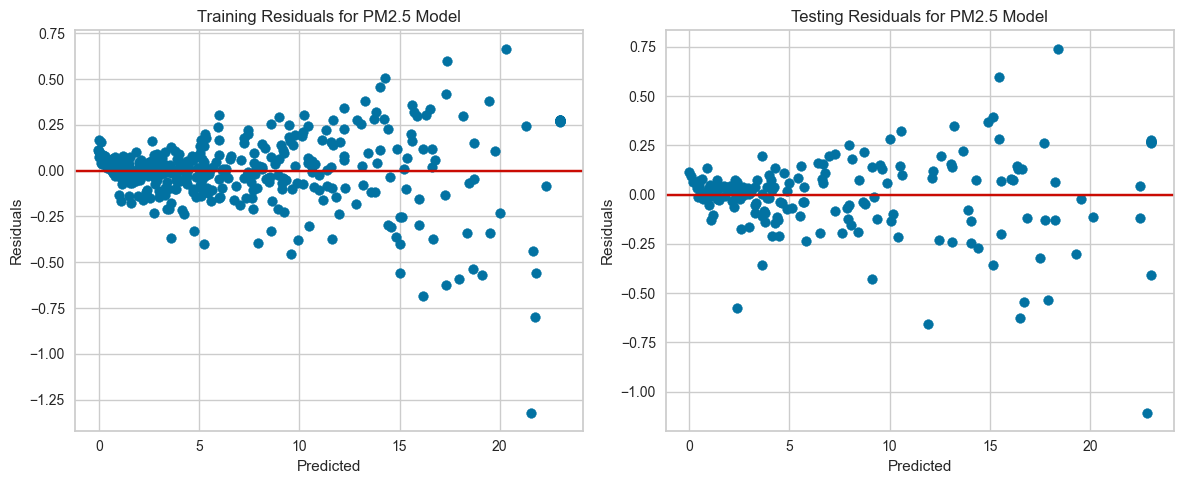

Training Residuals for PM2.5 Model - Mean: 0.0012849644990637898, Std: 0.18713641166687012
Testing Residuals for PM2.5 Model - Mean: -0.005317984148859978, Std: 0.2057589739561081


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,0.6290,0.6497,0.8060,0.7095,0.0271,0.0220


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,0.6239,0.6442,0.8027,0.6697,0.0269,0.0218


Index(['humidity', 'pm_10', 'pm_2_5', 'temperature', 'prediction_label'], dtype='object')


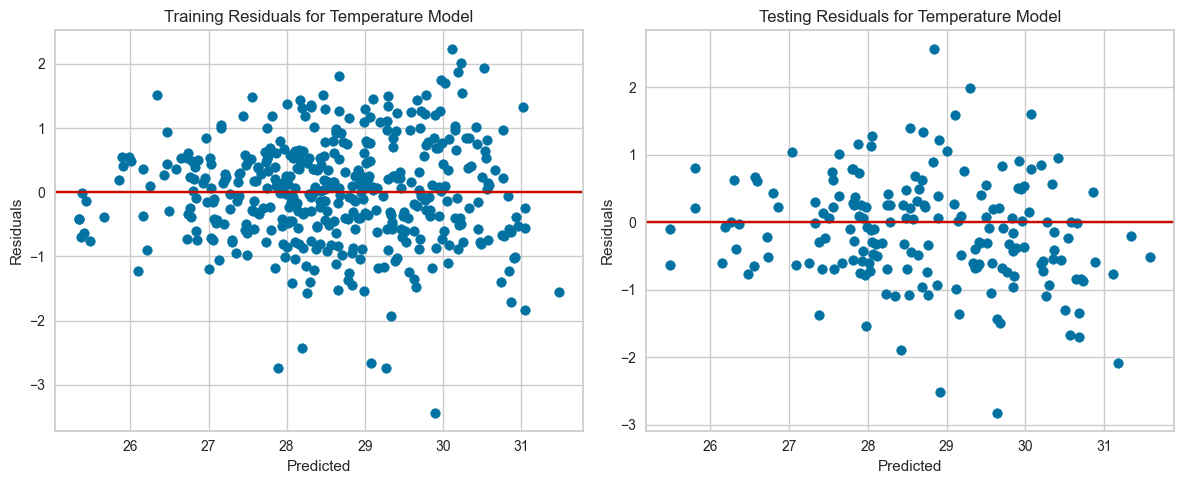

Training Residuals for Temperature Model - Mean: -1.5781844240336795e-06, Std: 0.8070026636123657
Testing Residuals for Temperature Model - Mean: -0.13991671800613403, Std: 0.7925423979759216
      humidity      pm_10  temperature     pm_2_5
563  83.313021   5.933670    28.027234   4.939508
604  74.136563   6.352747    29.337970   5.336689
570  84.685096  10.535271    26.900071   9.050794
444  90.974697   0.864394    26.240425   0.617391
304  76.314215  13.985586    29.693473  12.278298
humidity       float64
pm_10          float64
temperature    float64
pm_2_5         float64
dtype: object
Train data columns: ['humidity', 'pm_10', 'temperature', 'pm_2_5']
Train data sample:
      humidity      pm_10  temperature     pm_2_5
563  83.313021   5.933670    28.027234   4.939508
604  74.136563   6.352747    29.337970   5.336689
570  84.685096  10.535271    26.900071   9.050794
444  90.974697   0.864394    26.240425   0.617391
304  76.314215  13.985586    29.693473  12.278298


,Description,Value
0,Session id,456
1,Target,temperature
2,Target type,Regression
3,Original data shape,"(423, 4)"
4,Transformed data shape,"(423, 4)"
5,Transformed train set shape,"(296, 4)"
6,Transformed test set shape,"(127, 4)"
7,Numeric features,3
8,Preprocess,True
9,Imputation type,simple


In [31]:

# ส่วนที่ 17: ตรวจสอบความสำคัญของตัวแปรสำหรับโมเดลอุณหภูมิ
if hasattr(final_temp_model, 'feature_importances_'):
    importances_temp = pd.DataFrame({
        'feature': X.columns,
        'importance': final_temp_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=importances_temp)
    plt.title('Feature Importance for Temperature Model')
    plt.tight_layout()
    plt.show()
    
    print("Feature Importance for Temperature Model:\n", importances_temp)
# ส่วนที่ 17: วิเคราะห์ Residuals เพื่อตรวจสอบการ Overfit สำหรับโมเดล PM2.5
train_pred_pm25 = predict_model(final_pm25_model, data=train_data)
test_pred_pm25 = predict_model(final_pm25_model, data=test_data)

# ตรวจสอบชื่อคอลัมน์ในผลลัพธ์ของ predict_model
print(train_pred_pm25.columns)

# คำนวณ residuals สำหรับโมเดล PM2.5
train_residuals_pm25 = train_pred_pm25['pm_2_5'] - train_pred_pm25['prediction_label']
test_residuals_pm25 = test_pred_pm25['pm_2_5'] - test_pred_pm25['prediction_label']

# แสดงกราฟ residuals สำหรับโมเดล PM2.5
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(train_pred_pm25['prediction_label'], train_residuals_pm25)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Training Residuals for PM2.5 Model')

plt.subplot(1, 2, 2)
plt.scatter(test_pred_pm25['prediction_label'], test_residuals_pm25)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Testing Residuals for PM2.5 Model')

plt.tight_layout()
plt.show()

# แสดงค่าเฉลี่ยและส่วนเบี่ยงเบนมาตรฐานของ residuals สำหรับโมเดล PM2.5
print(f"Training Residuals for PM2.5 Model - Mean: {train_residuals_pm25.mean()}, Std: {train_residuals_pm25.std()}")
print(f"Testing Residuals for PM2.5 Model - Mean: {test_residuals_pm25.mean()}, Std: {test_residuals_pm25.std()}")

# ส่วนที่ 18: วิเคราะห์ Residuals เพื่อตรวจสอบการ Overfit สำหรับโมเดลอุณหภูมิ
train_pred_temp = predict_model(final_temp_model, data=train_data)
test_pred_temp = predict_model(final_temp_model, data=test_data)

# ตรวจสอบชื่อคอลัมน์ในผลลัพธ์ของ predict_model
print(train_pred_temp.columns)

# คำนวณ residuals สำหรับโมเดลอุณหภูมิ
train_residuals_temp = train_pred_temp['temperature'] - train_pred_temp['prediction_label']
test_residuals_temp = test_pred_temp['temperature'] - test_pred_temp['prediction_label']

# แสดงกราฟ residuals สำหรับโมเดลอุณหภูมิ
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(train_pred_temp['prediction_label'], train_residuals_temp)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Training Residuals for Temperature Model')

plt.subplot(1, 2, 2)
plt.scatter(test_pred_temp['prediction_label'], test_residuals_temp)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Testing Residuals for Temperature Model')

plt.tight_layout()
plt.show()

# แสดงค่าเฉลี่ยและส่วนเบี่ยงเบนมาตรฐานของ residuals สำหรับโมเดลอุณหภูมิ
print(f"Training Residuals for Temperature Model - Mean: {train_residuals_temp.mean()}, Std: {train_residuals_temp.std()}")
print(f"Testing Residuals for Temperature Model - Mean: {test_residuals_temp.mean()}, Std: {test_residuals_temp.std()}")

# ตรวจสอบข้อมูลใน train_data
print(train_data.head())
print(train_data.dtypes)
print("Train data columns:", train_data.columns.tolist())
print("Train data sample:")
print(train_data.head())

# PyCaret setup
exp_temp = setup(
    data=train_data, 
    target='temperature', 
    session_id=456,
    fold=5,
    feature_selection=False,
    remove_multicollinearity=False,
    verbose=True
)



,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,0.6290,0.6497,0.8060,0.7095,0.0271,0.0220


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,0.6239,0.6442,0.8027,0.6697,0.0269,0.0218


Index(['humidity', 'pm_10', 'pm_2_5', 'temperature', 'prediction_label'], dtype='object')


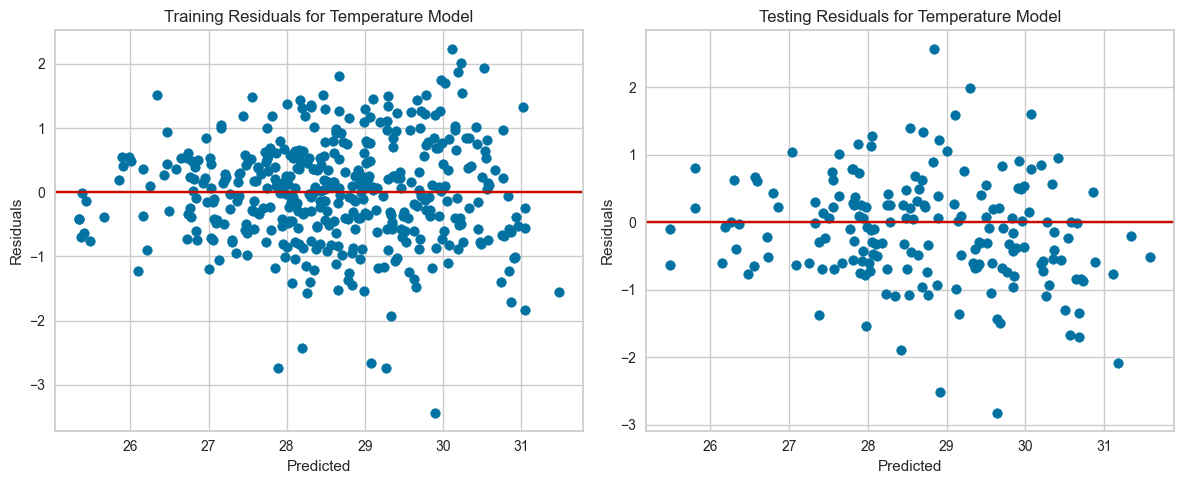

Training Residuals for Temperature Model - Mean: -1.5781844240336795e-06, Std: 0.8070026636123657
Testing Residuals for Temperature Model - Mean: -0.13991671800613403, Std: 0.7925423979759216
      humidity      pm_10  temperature     pm_2_5
563  83.313021   5.933670    28.027234   4.939508
604  74.136563   6.352747    29.337970   5.336689
570  84.685096  10.535271    26.900071   9.050794
444  90.974697   0.864394    26.240425   0.617391
304  76.314215  13.985586    29.693473  12.278298
humidity       float64
pm_10          float64
temperature    float64
pm_2_5         float64
dtype: object
Train data columns: ['humidity', 'pm_10', 'temperature', 'pm_2_5']
Train data sample:
      humidity      pm_10  temperature     pm_2_5
563  83.313021   5.933670    28.027234   4.939508
604  74.136563   6.352747    29.337970   5.336689
570  84.685096  10.535271    26.900071   9.050794
444  90.974697   0.864394    26.240425   0.617391
304  76.314215  13.985586    29.693473  12.278298


,Description,Value
0,Session id,456
1,Target,temperature
2,Target type,Regression
3,Original data shape,"(423, 4)"
4,Transformed data shape,"(423, 4)"
5,Transformed train set shape,"(296, 4)"
6,Transformed test set shape,"(127, 4)"
7,Numeric features,3
8,Preprocess,True
9,Imputation type,simple


In [32]:
# ส่วนที่ 18: วิเคราะห์ Residuals เพื่อตรวจสอบการ Overfit สำหรับโมเดลอุณหภูมิ
train_pred_temp = predict_model(final_temp_model, data=train_data)
test_pred_temp = predict_model(final_temp_model, data=test_data)

# ตรวจสอบชื่อคอลัมน์ในผลลัพธ์ของ predict_model
print(train_pred_temp.columns)

# คำนวณ residuals สำหรับโมเดลอุณหภูมิ
train_residuals_temp = train_pred_temp['temperature'] - train_pred_temp['prediction_label']
test_residuals_temp = test_pred_temp['temperature'] - test_pred_temp['prediction_label']

# แสดงกราฟ residuals สำหรับโมเดลอุณหภูมิ
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(train_pred_temp['prediction_label'], train_residuals_temp)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Training Residuals for Temperature Model')

plt.subplot(1, 2, 2)
plt.scatter(test_pred_temp['prediction_label'], test_residuals_temp)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Testing Residuals for Temperature Model')

plt.tight_layout()
plt.show()

# แสดงค่าเฉลี่ยและส่วนเบี่ยงเบนมาตรฐานของ residuals สำหรับโมเดลอุณหภูมิ
print(f"Training Residuals for Temperature Model - Mean: {train_residuals_temp.mean()}, Std: {train_residuals_temp.std()}")
print(f"Testing Residuals for Temperature Model - Mean: {test_residuals_temp.mean()}, Std: {test_residuals_temp.std()}")

# ตรวจสอบข้อมูลใน train_data
print(train_data.head())
print(train_data.dtypes)
print("Train data columns:", train_data.columns.tolist())
print("Train data sample:")
print(train_data.head())

# PyCaret setup
exp_temp = setup(
    data=train_data, 
    target='temperature', 
    session_id=456,
    fold=5,
    feature_selection=False,
    remove_multicollinearity=False,
    verbose=True
)